# Miniproject: Modelling the climate or the weather?

Is past performance an indicator of future weather?

## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe. 

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.


### Machine Learning Tasks: 
1. Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?  [Later in the term files containing the 2021 data will be made available
2. Can you design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) any better than assuming that the weather tomorrow will be exactly the same as the weather today

### Potential extensions
1. Can you train a machine learning technique to predict 10 or 20 years into the future?
2. Where will the hotest part of the world be in 20 years time?
3. What else can you study with this dataset? Is the sun in Utah a predictor of the rain in Spain? 
4. How close do weather stations need to be to provide reliable forecasts at other stations?

### Caveats
This is real data from weather stations around the world. This means that there are 'holes' in the data. You must be able to handle these 'holes' in some error tolerant fashion.


In [1]:
# import the urllib library
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt 
 
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]
        
    

In [2]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [3]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# Arbitrary number from 0 to 990
whichStat=220
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))


CA002400404 is ARCTIC BAY CS, Canada at 73.0, -85.0167, 10.0


5341


Text(0, 0.5, 'Temperature (C)')

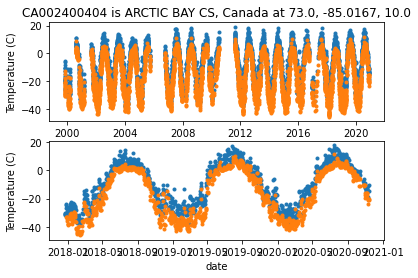

In [4]:
tmaxArray=ghn.getVar(statDict,'TMAX')
days, tmax = zip(*tmaxArray)
tminArray=ghn.getVar(statDict,'TMIN')
days2, tmin = zip(*tminArray)
print(len(days))
fig, ax = plt.subplots(2,1)
ax[0].plot(days,tmax,'.')
ax[0].plot(days2,tmin,'.')
ax[0].set_xlabel("date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[whichStat]))
ax[1].plot(days[-1000:],tmax[-1000:],'.')
ax[1].plot(days2[-1000:],tmin[-1000:],'.')
ax[1].set_xlabel("date")
ax[1].set_ylabel("Temperature (C)")

In [5]:

numberofstations = np.arange(0,991,1)
dataframenames = ['TMAX','TMIN','PRCP','SNOW','SNWD']


def whichStatandVardatapoints(desireddatapoints):
    '''Determines the amount of data a given variable has for a given station '''
    for i in numberofstations:
        fileName=statNames[i]+'.dly'
        urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

        # Copy a network object to a local file
        urllib.request.urlretrieve(urlName,fileName)
        statDict=ghn.processFile(fileName)
        try:
            tmaxArray=ghn.getVar(statDict,'{}'.format(dataframenames[0]))
            #tmaxdays, tmax = zip(*tmaxArray)
            if np.shape(tmaxArray)[0] > desireddatapoints:
                print('{} which corresponds to station number {} has {} data points for variable {}'.format(statNames[i],i,np.shape(tmaxArray)[0],dataframenames[0]))
            else:
                continue
            
            tminArray=ghn.getVar(statDict,'{}'.format(dataframenames[1]))
            #tmindays, tmin = zip(*tminArray)
            if np.shape(tminArray)[0] > desireddatapoints:
                print('{} which corresponds to station number {} has {} data points for variable {}'.format(statNames[i],i,np.shape(tminArray)[0],dataframenames[1]))
            else:
                continue

            prcpArray=ghn.getVar(statDict,'{}'.format(dataframenames[2]))
            #prcpdays, prcp = zip(*prcpArray)
            if np.shape(prcpArray)[0] > desireddatapoints:
                print('{} which corresponds to station number {} has {} data points for variable {}'.format(statNames[i],i,np.shape(prcpArray)[0],dataframenames[2]))
            else:
                continue

            snowArray=ghn.getVar(statDict,'{}'.format(dataframenames[3]))
            #snowdays, snow = zip(*snowArray)
            if np.shape(snowArray)[0] > desireddatapoints:
                print('{} which corresponds to station number {} has {} data points for variable {}'.format(statNames[i],i,np.shape(snowArray)[0],dataframenames[3]))
            else:
                continue

            snwdArray=ghn.getVar(statDict,'{}'.format(dataframenames[4]))
            #snwddays, snwd = zip(*snwdArray)
            if np.shape(snwdArray)[0] > desireddatapoints:
                print('{} which corresponds to station number {} has {} data points for variable {}'.format(statNames[i],i,np.shape(snwdArray)[0],dataframenames[4]))
            else:
                continue
            
        except KeyError:
            continue

# Code to ignore KeyError adapted from
# https://stackoverflow.com/questions/15653966/ignore-keyerror-and-continue-program

# KeyError shows up when trying to extract data for a variable which a station has no record of.
# (Some stations do not have records for all the variables)

In [6]:
# Be useful to have a list of station number and station name
# as it will help us identify which numbers in statNames
# corresponds to stations in a specific country
# (first two lettes in station code define which country station is in)

numberofstations = np.arange(0,991,1)
#print(numberofstations)
#print(len(numberofstations))

for i in numberofstations:
    print(f'Station',i,'corresponds to',statNames[i])

Station 0 corresponds to AE000041196
Station 1 corresponds to AF000040930
Station 2 corresponds to AG000060390
Station 3 corresponds to AG000060590
Station 4 corresponds to AG000060611
Station 5 corresponds to AG000060680
Station 6 corresponds to AJ000037989
Station 7 corresponds to ALM00013615
Station 8 corresponds to AM000037781
Station 9 corresponds to AO000066160
Station 10 corresponds to AO000066270
Station 11 corresponds to AO000066390
Station 12 corresponds to AO000066410
Station 13 corresponds to AO000066422
Station 14 corresponds to AO000066447
Station 15 corresponds to AQW00061705
Station 16 corresponds to AR000087007
Station 17 corresponds to AR000087065
Station 18 corresponds to AR000087078
Station 19 corresponds to AR000087155
Station 20 corresponds to AR000087217
Station 21 corresponds to AR000087257
Station 22 corresponds to AR000087270
Station 23 corresponds to AR000087344
Station 24 corresponds to AR000087374
Station 25 corresponds to AR000087418
Station 26 corresponds

Station 957 corresponds to USW00093820
Station 958 corresponds to USW00094008
Station 959 corresponds to USW00094823
Station 960 corresponds to UV000065501
Station 961 corresponds to UV000065516
Station 962 corresponds to UY000001709
Station 963 corresponds to UY000086330
Station 964 corresponds to UY000086490
Station 965 corresponds to UY000086565
Station 966 corresponds to UZM00038262
Station 967 corresponds to UZM00038413
Station 968 corresponds to UZM00038457
Station 969 corresponds to VE000080405
Station 970 corresponds to VE000080423
Station 971 corresponds to VE000080425
Station 972 corresponds to VE000080438
Station 973 corresponds to VE000080450
Station 974 corresponds to VE000080453
Station 975 corresponds to VE000080462
Station 976 corresponds to VM000048900
Station 977 corresponds to VMM00048855
Station 978 corresponds to WA004191820
Station 979 corresponds to WA006490640
Station 980 corresponds to WA007401540
Station 981 corresponds to WA010101860
Station 982 corresponds t

In [7]:
whichStatandVardatapoints(30000)

ASN00009518 which corresponds to station number 55 has 41490 data points for variable TMAX
ASN00009518 which corresponds to station number 55 has 41254 data points for variable TMIN
ASN00009518 which corresponds to station number 55 has 41582 data points for variable PRCP
ASN00030045 which corresponds to station number 77 has 45382 data points for variable TMAX
ASN00030045 which corresponds to station number 77 has 45142 data points for variable TMIN
ASN00030045 which corresponds to station number 77 has 44695 data points for variable PRCP
ASN00031010 which corresponds to station number 79 has 31907 data points for variable TMAX
ASN00046037 which corresponds to station number 88 has 36258 data points for variable TMAX
ASN00046037 which corresponds to station number 88 has 35522 data points for variable TMIN
ASN00046037 which corresponds to station number 88 has 46215 data points for variable PRCP
ASN00090015 which corresponds to station number 102 has 56570 data points for variable TMA

KZ000035108 which corresponds to station number 508 has 36617 data points for variable PRCP
KZ000035394 which corresponds to station number 509 has 30244 data points for variable TMAX
KZ000035416 which corresponds to station number 510 has 32495 data points for variable TMAX
KZ000035416 which corresponds to station number 510 has 37645 data points for variable TMIN
KZ000035796 which corresponds to station number 511 has 30233 data points for variable TMAX
KZ000035849 which corresponds to station number 512 has 35611 data points for variable TMAX
KZ000035849 which corresponds to station number 512 has 41483 data points for variable TMIN
KZ000035849 which corresponds to station number 512 has 41743 data points for variable PRCP
KZ000036177 which corresponds to station number 514 has 36619 data points for variable TMAX
KZ000036177 which corresponds to station number 514 has 39634 data points for variable TMIN
KZ000036177 which corresponds to station number 514 has 36837 data points for va

RSM00023678 which corresponds to station number 686 has 39836 data points for variable PRCP
RSM00023711 which corresponds to station number 687 has 37915 data points for variable TMAX
RSM00023711 which corresponds to station number 687 has 46791 data points for variable TMIN
RSM00023711 which corresponds to station number 687 has 47399 data points for variable PRCP
RSM00023891 which corresponds to station number 690 has 30212 data points for variable TMAX
RSM00023891 which corresponds to station number 690 has 30611 data points for variable TMIN
RSM00023891 which corresponds to station number 690 has 30794 data points for variable PRCP
RSM00023914 which corresponds to station number 691 has 36504 data points for variable TMAX
RSM00023914 which corresponds to station number 691 has 44193 data points for variable TMIN
RSM00023914 which corresponds to station number 691 has 47563 data points for variable PRCP
RSM00023933 which corresponds to station number 692 has 31281 data points for va

RSM00028722 which corresponds to station number 741 has 42139 data points for variable TMIN
RSM00028722 which corresponds to station number 741 has 41692 data points for variable PRCP
RSM00029231 which corresponds to station number 742 has 31166 data points for variable TMAX
RSM00029231 which corresponds to station number 742 has 31000 data points for variable TMIN
RSM00029231 which corresponds to station number 742 has 30940 data points for variable PRCP
RSM00029263 which corresponds to station number 743 has 34689 data points for variable TMAX
RSM00029263 which corresponds to station number 743 has 47518 data points for variable TMIN
RSM00029263 which corresponds to station number 743 has 49145 data points for variable PRCP
RSM00029282 which corresponds to station number 744 has 32490 data points for variable TMAX
RSM00029282 which corresponds to station number 744 has 32346 data points for variable TMIN
RSM00029282 which corresponds to station number 744 has 32768 data points for va

RSM00031960 which corresponds to station number 773 has 36201 data points for variable PRCP
RSM00032061 which corresponds to station number 774 has 41989 data points for variable TMAX
RSM00032061 which corresponds to station number 774 has 46840 data points for variable TMIN
RSM00032061 which corresponds to station number 774 has 47324 data points for variable PRCP
RSM00032098 which corresponds to station number 775 has 40443 data points for variable TMAX
RSM00032098 which corresponds to station number 775 has 40627 data points for variable TMIN
RSM00032098 which corresponds to station number 775 has 40707 data points for variable PRCP
RSM00032389 which corresponds to station number 778 has 32871 data points for variable TMAX
RSM00032389 which corresponds to station number 778 has 35284 data points for variable TMIN
RSM00032389 which corresponds to station number 778 has 35049 data points for variable PRCP
RSM00032618 which corresponds to station number 779 has 35350 data points for va

USW00014838 which corresponds to station number 913 has 34041 data points for variable PRCP
USW00014922 which corresponds to station number 915 has 30167 data points for variable TMAX
USW00014922 which corresponds to station number 915 has 30166 data points for variable TMIN
USW00014922 which corresponds to station number 915 has 30167 data points for variable PRCP
USW00014936 which corresponds to station number 917 has 50896 data points for variable TMAX
USW00014936 which corresponds to station number 917 has 50897 data points for variable TMIN
USW00014936 which corresponds to station number 917 has 50898 data points for variable PRCP
USW00014936 which corresponds to station number 917 has 46636 data points for variable SNOW
USW00014936 which corresponds to station number 917 has 46694 data points for variable SNWD
USW00023044 which corresponds to station number 921 has 30169 data points for variable TMAX
USW00023044 which corresponds to station number 921 has 30169 data points for va